# The dataset

https://snap.stanford.edu/data/email-Eu-core.html

In [2]:
# from pyspark import SparkContext
# from pyspark.sql import SparkSession
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

C:\Users\aligh\AppData\Local\Temp\ipykernel_89840\206557912.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# # Create a SparkContext
# sc = SparkContext()

# # Create a SparkSession
# spark = SparkSession.builder.getOrCreate('CommunityDetection', sc)


## Step 1: Load the Data

In [4]:
# Load email communications
emails_df = pd.read_csv('data/email-Eu-core.txt', sep=' ', header=None, names=['sender', 'receiver'])

# Load department labels
departments_df = pd.read_csv('data/email-Eu-core-department-labels.txt', sep=' ', header=None, names=['member', 'department'])
# Add department labels as node attributes
department_dict = departments_df.set_index('member')['department'].to_dict()

## Step 2: Build the graph

#### Filter the recursive nodes

In [5]:
emails_df = emails_df[emails_df['sender'] != emails_df['receiver']]
emails_df.head()

,sender,receiver
0,0,1
1,2,3
2,2,4
3,5,6
4,5,7


#### Let us test that graph is successfully built by a small sample `nodeId` [0-5]

In [6]:
filtered_emails_df = emails_df[(emails_df['sender'] >= 0) & (emails_df['sender'] <= 5) & (emails_df['receiver'] >= 0) & (emails_df['receiver'] <= 5)]
filtered_emails_df


,sender,receiver
0,0,1
1,2,3
2,2,4
138,4,2
139,4,3
1212,3,2
1838,3,4
3485,5,2
5183,2,5
14670,0,5


In [7]:
def build_graph_from_adjacency_list(adj_df, departments_df):
        
    G = nx.from_pandas_edgelist(adj_df, 'sender', 'receiver')
    nx.set_node_attributes(G, department_dict, 'department')

    plt.figure(figsize=(8, 6))
    nx.draw(G, with_labels=True, node_color='lightblue', edge_color='grey', node_size=800, font_size=6, font_weight='bold', font_color='black', width=0.5, alpha=0.7)
    return G

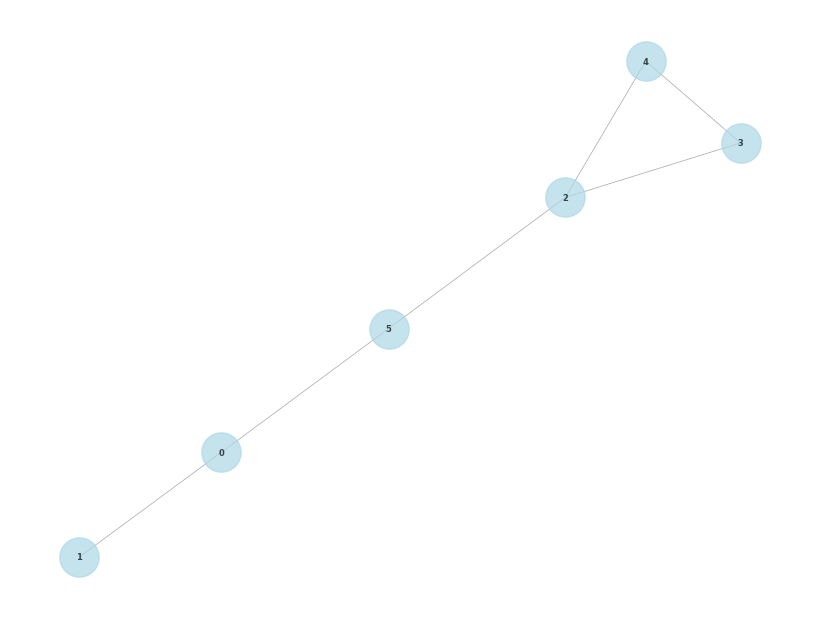

In [11]:
G = build_graph_from_adjacency_list(filtered_emails_df, departments_df)

### Now let us create full graph of the data

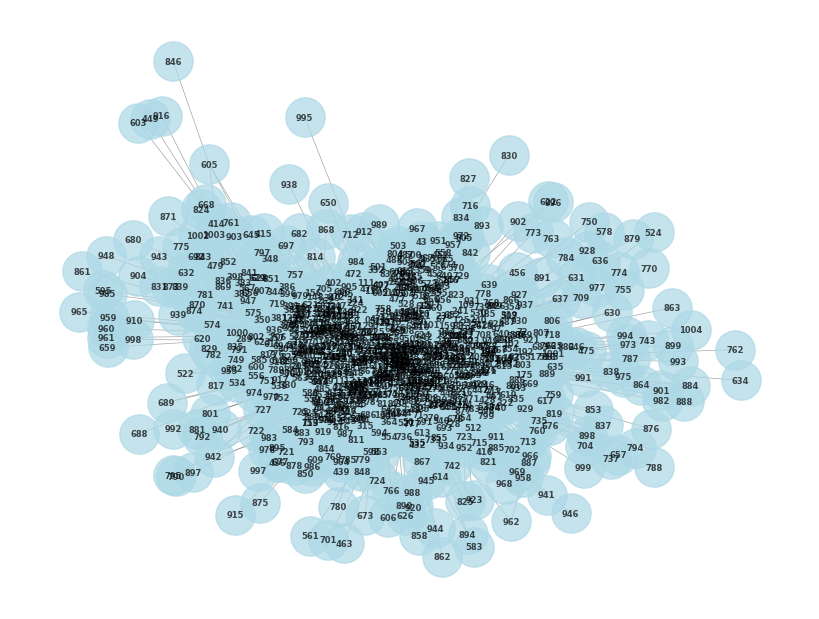

In [13]:
G = build_graph_from_adjacency_list(emails_df, departments_df)

### Let us plot the distribution of the departments

In [14]:
from collections import Counter

department_counts = Counter(department_dict.values())
print(department_counts)


Counter({4: 109, 14: 92, 1: 65, 21: 61, 15: 55, 7: 51, 0: 49, 10: 39, 17: 35, 9: 32, 11: 29, 19: 29, 6: 28, 23: 27, 13: 26, 22: 25, 16: 25, 36: 22, 8: 19, 5: 18, 37: 15, 20: 14, 34: 13, 38: 13, 35: 13, 3: 12, 27: 10, 2: 10, 26: 9, 32: 9, 28: 8, 31: 8, 25: 6, 24: 6, 29: 5, 40: 4, 30: 4, 39: 3, 12: 3, 41: 2, 18: 1, 33: 1})


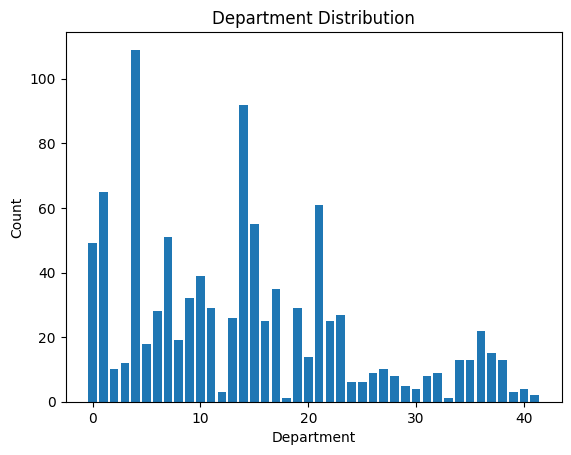

In [15]:
plt.bar(department_counts.keys(), department_counts.values())
plt.xlabel('Department')
plt.ylabel('Count')
plt.title('Department Distribution')
plt.show()


To retrieve the department of associated node

In [16]:
nodeId = 2
department = G.nodes[nodeId]['department']
print(f"The department of node {nodeId} is {department}")


The department of node 2 is 21


## Step 4: Extract the Adjacency Matrix

*Notice:* The data is inclusive of recursive nodes

In [17]:
adjacency_matrix = nx.adjacency_matrix(G)

# Convert the adjacency matrix to a dense format for display purposes
adjacency_matrix_dense = adjacency_matrix.todense()

# Display the adjacency matrix as a DataFrame for better readability
df_adjacency_matrix = pd.DataFrame(adjacency_matrix_dense, index=G.nodes(), columns=G.nodes())
df_adjacency_matrix

,0,1,2,3,4,5,6,7,8,9,...,996,997,763,998,999,1000,1001,1002,1003,1004
0,0,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1001,0,0,1,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Louvain Algorithm

## Introduction
The Louvain algorithm is a community detection algorithm designed for large networks. It aims to maximize the modularity score for each community, evaluating how densely connected nodes are within a community compared to random networks. More information on the Louvain method can be found [here](https://en.wikipedia.org/wiki/Louvain_method).

## Library
Community detection will be performed using the [community](https://python-louvain.readthedocs.io/en/latest/api.html) library in conjunction with NetworkX.

## Steps

### Finding Communities
In this phase, the algorithm follows these steps:
1. **Initialization**: Each node is initially assigned to its own community.
2. **Modularity Optimization**: For each node, the algorithm seeks the maximum positive modularity gain by exploring potential moves to all neighbor communities. If no positive gain is achieved, the node remains in its original community.
######  **Assign final results**: finally we will assign each node it's community as an attribute to be used later
### Displaying the Results
This section showcases the community results in two ways:

- **Static Display**: All nodes are visualized in a single image, with each community represented by a distinct color.
- **Interactive Display**: Utilizing the *pyvis* library, an interactive page is generated to display the top-10 nodes within each community.

For more detailed information, please refer to the code documentation.


#### Finding Communities

In [24]:
# louvain community detection
from community import community_louvain
partition = community_louvain.best_partition(G)


#### add community as attribure


In [25]:
# Add the partition as a node attribute
nx.set_node_attributes(G, partition, 'louvain_community')

In [28]:
# show the number of communities
num_communities = len(set(partition.values()))
print(f"The number of communities detected is {num_communities}")

The number of communities detected is 7


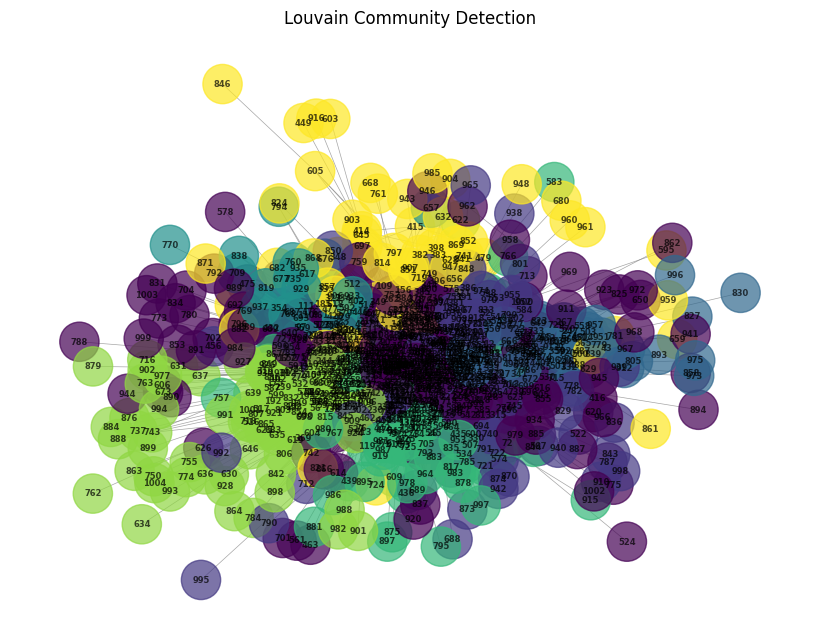

In [29]:
# Create a list of colors for the nodes based on their community
colors = [partition[n] for n in G.nodes()]
# Draw the graph with the colors
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color=colors, edge_color='grey', node_size=800, font_size=6, font_weight='bold', font_color='black', width=0.5, alpha=0.7)
plt.title('Louvain Community Detection')
plt.show()

#### Visalization for the Graph
<small>The following code will generate an html webpage with needed information in *./lib* directry 
- You need LiveServer install in order to visualize the results
- once the *Louvain.html* is created
    - go to the directory *./Louvain.html* 
    - start LiveServer
    </small>

In [39]:
# provide zoomable graph for better visualization
import pyvis
from pyvis.network import Network
net = Network(notebook=True)
# get top 10 nodes for each community
top_nodes = {community: [] for community in set(partition.values())}
for node, community in partition.items():
    if len(top_nodes[community]) < 10:
        top_nodes[community].append(node)
# add the nodes and edges to the network with colors
for community, nodes in top_nodes.items():
    for node in nodes:
        net.add_node(node, label=node)
    for sender, receiver in G.edges():
        if sender in nodes and receiver in nodes:
            net.add_edge(sender, receiver)
# build a color map for the nodes based on their community with hex colors
color_map = {community: f"#{np.random.choice(range(256**3)):06x}" for community in set(partition.values())}
# for each node in the network, add the color and size to the node
for node in net.nodes:
    node['color'] = color_map.get(colors[node['id']])
    node['size'] = 10

# show the network
net.show("Louvain.html")


Louvain.html


In [43]:
# make a table for the top_nodes with it's communities 
# show node_id, community, department
top_nodes_df = pd.DataFrame(columns=['node_id', 'community', 'department'])
for community, nodes in top_nodes.items():
    for node in nodes:
        top_nodes_df = pd.concat([top_nodes_df, pd.DataFrame({'node_id': node, 'community': community, 'department': G.nodes[node]['department']}, index=[0])], ignore_index=True)
top_nodes_df

,node_id,community,department
0,0,0,1
1,1,0,1
2,10,0,9
3,16,0,34
4,17,0,1
...,...,...,...
65,122,6,0
66,130,6,0
67,148,6,0
68,149,6,0


In [45]:
# show number of communities, number of departments, number of nodes
num_communities = len(set(partition.values()))
num_departments = len(set(department_dict.values()))
num_nodes = len(G.nodes())
print(f"The number of communities detected is {num_communities}")
print(f"The number of departments is {num_departments}")
print(f"The number of nodes is {num_nodes}")

The number of communities detected is 7
The number of departments is 42
The number of nodes is 986
